In [2]:
!pip install rl4co

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.1/336.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 988.0/988.0 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 58.3 MB/s eta 0:

In [1]:
%load_ext autoreload
%autoreload 2

import torch

from rl4co.envs import TSPEnv
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer

In [2]:
# RL4CO env based on TorchRL
env = TSPEnv(
    generator_params=dict(num_loc=50)
)

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(
    env_name=env.name,
    embed_dim=128,
    num_encoder_layers=3,
    num_heads=8,
)

# RL Model: RENFORCE and greedy rollout baseline
model = REINFORCE(
    env=env,
    policy=policy,
    baseline="rollout",
    batch_size=512,
    train_data_size=100_000,
    val_data_size=10_000,
    optimizer_kwargs=dict(
        lr=1e-4
    )
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


## Test greedy rollout with untrained model and plot

Proble 1 | Cost: 11.451
Proble 2 | Cost: 9.896
Proble 3 | Cost: 9.677


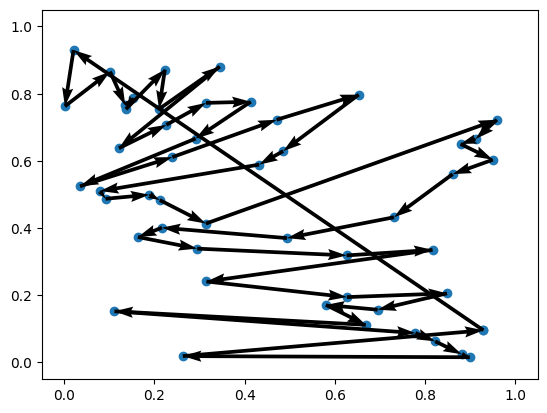

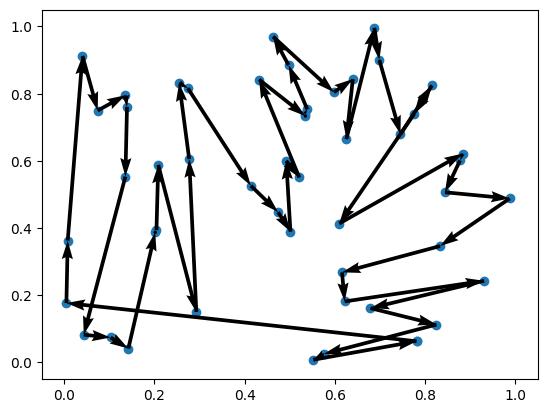

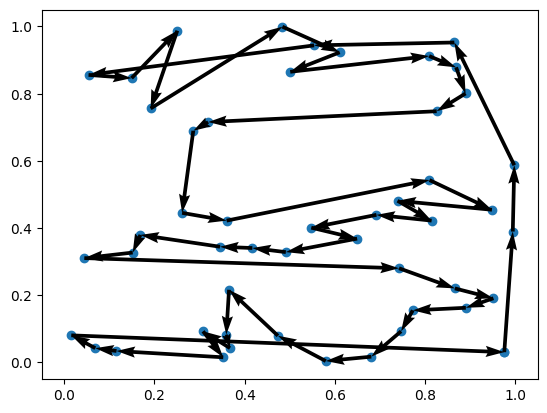

In [3]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = policy.to(device)
out = policy(
    td_init.clone(),
    phase="test",
    decode_type="greedy",
    return_actions=True
)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Proble {i + 1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

## Trainer
The RL4CO trainer is a wrapper around Pytorch Lighting's Trainer class which adds some functionality and more efficient defaults

In [4]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None
)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Fit the model

In [5]:
trainer.fit(model)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | env      | TSPEnv               | 0      | train
1 | policy   | AttentionModelPolicy | 710 K  | train
2 | baseline | WarmupBaseline       | 710 K  | train
----------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)
72        Modules in train mode
68        Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | env      | TSPEnv               | 0      | train
1 | policy   | AttentionModelPolicy | 710 K  | train
2 | baseline | WarmupBaseline       | 710 K  | train
--------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


## Testing

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


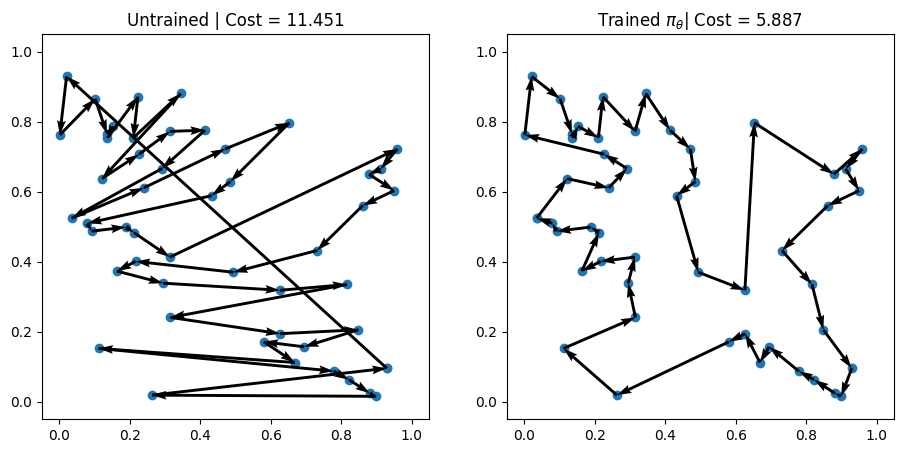

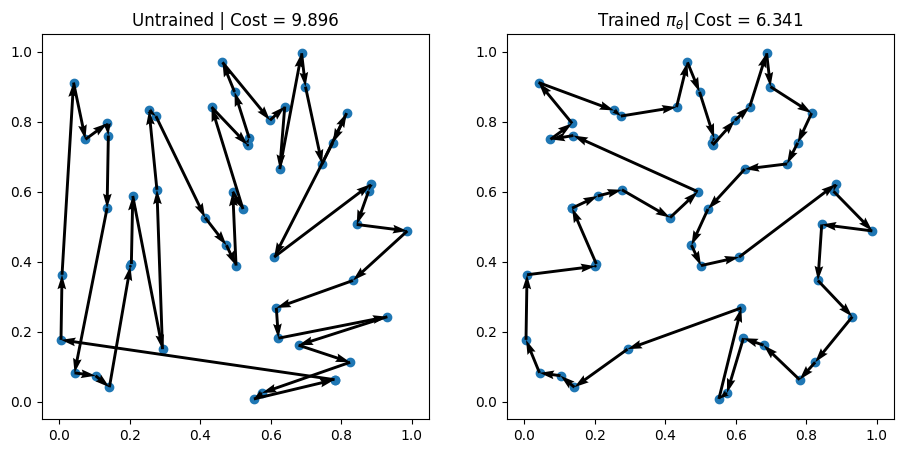

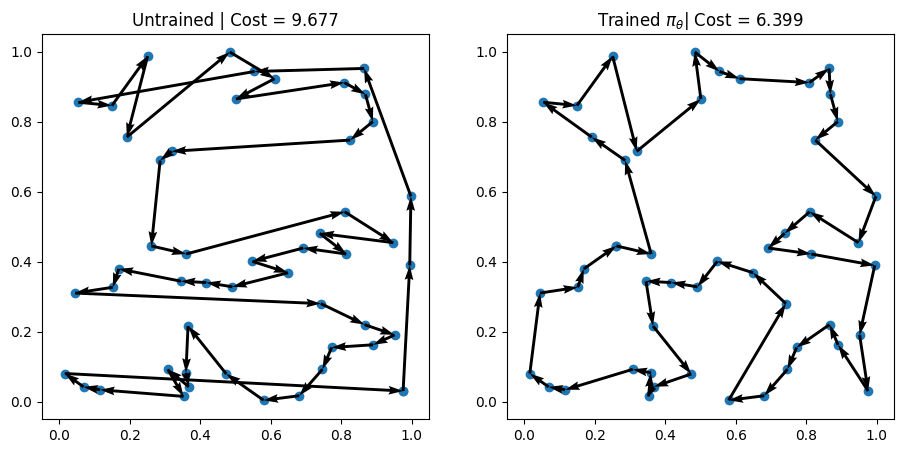

In [6]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(
    td_init.clone(),
    phase="test",
    decode_type="greedy",
    return_actions=True
)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1, 2, figsize=(11, 5))
    env.render(td, actions_untrained[i], ax=axs[0])
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")